# Reviews de Amazon basado en NLP - Proyecto Final
#### **Objetivo: Predicción de ratings basado en reviews de videojuegos vendidos Amazon**

En la plataforma de Amazon, los usuarios pueden ingresar sus comentarios y ratings con respecto a un producto adquirido. Sin embargo, muchos usuarios solo colocan un review, lo cual dificulta a Amazon mantener un registro de calificaciones por cada uno de sus registros. Por ello, este modelo busca predecir la clasificación dada a raíz de un comentario mediante un sistema de rating del 1 al 5.

- Input: El videojuego es increíble. Garantiza muchas horas de diversión!
- Output: 5

# Importar librerias

In [1]:
import pandas as pd
import numpy as np
## Librerias para graficación
import matplotlib.pyplot as plt
import seaborn as sns

# Cargar el Dataset

## Lectura del dataset

In [2]:
!wget "https://huggingface.co/api/datasets/amazon_us_reviews/parquet/Video_Games_v1_00/train/0.parquet"
!wget "https://huggingface.co/api/datasets/amazon_us_reviews/parquet/Video_Games_v1_00/train/1.parquet"
!wget "https://huggingface.co/api/datasets/amazon_us_reviews/parquet/Video_Games_v1_00/train/2.parquet"

'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.
'wget' is not recognized as an internal or external command,
operable program or batch file.


In [3]:
# Se leen todos los datasets y se unen en uno solo
df0 = pd.read_parquet("0.parquet")
df1 = pd.read_parquet("1.parquet")
df2 = pd.read_parquet("2.parquet")
df = pd.concat([df0, df1, df2], axis=0)

In [4]:
df.shape

(1785997, 15)

In [5]:
df.head(5)

,marketplace,customer_id,review_id,product_id,product_parent,product_title,product_category,star_rating,helpful_votes,total_votes,vine,verified_purchase,review_headline,review_body,review_date
0,US,12039526,RTIS3L2M1F5SM,B001CXYMFS,737716809,Thrustmaster T-Flight Hotas X Flight Stick,Video Games,5,0,0,0,1,an amazing joystick. I especially love that yo...,"Used this for Elite Dangerous on my mac, an am...",2015-08-31
1,US,9636577,R1ZV7R40OLHKD,B00M920ND6,569686175,Tonsee 6 buttons Wireless Optical Silent Gamin...,Video Games,5,0,0,0,1,Definitely a silent mouse... Not a single clic...,"Loved it, I didn't even realise it was a gami...",2015-08-31
2,US,2331478,R3BH071QLH8QMC,B0029CSOD2,98937668,Hidden Mysteries: Titanic Secrets of the Fatef...,Video Games,1,0,1,0,1,One Star,poor quality work and not as it is advertised.,2015-08-31
3,US,52495923,R127K9NTSXA2YH,B00GOOSV98,23143350,GelTabz Performance Thumb Grips - PlayStation ...,Video Games,3,0,0,0,1,"good, but could be bettee","nice, but tend to slip away from stick in inte...",2015-08-31
4,US,14533949,R32ZWUXDJPW27Q,B00Y074JOM,821342511,Zero Suit Samus amiibo - Japan Import (Super S...,Video Games,4,0,0,0,1,Great but flawed.,"Great amiibo, great for collecting. Quality ma...",2015-08-31


C:\Users\pms_l\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(9.444444444444445, 0.5, 'Conteo')

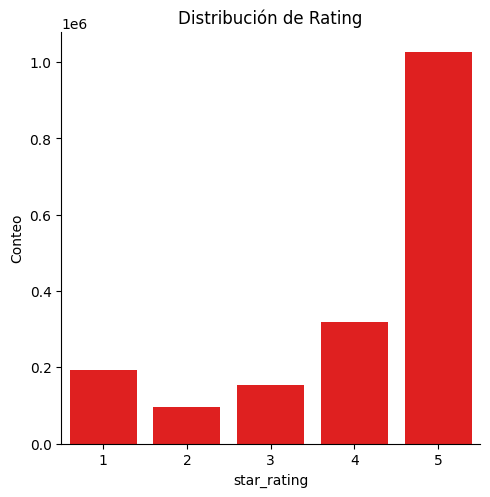

In [6]:
sns.catplot(x='star_rating', kind='count', color='r', data=df)
plt.title('Distribución de Rating')
plt.xlabel('star_rating')
plt.ylabel('Conteo')

## Sample del dataset

In [7]:
# Funcion para balancear el dataset
def balancear_dataset_por_rating(data_frame):
    # Obtenemos el recuento de cada valor de "rating"
    conteo_ratings = data_frame['star_rating'].value_counts()

    # Obtenemos el mínimo de ocurrencias de "rating" que queremos mantener
    min_ocurrencias = min(conteo_ratings)

    # Filtramos las filas que tienen "rating" mayor o igual al mínimo especificado
    data_frame_balanceado = data_frame.groupby('star_rating').apply(lambda x: x.sample(min_ocurrencias, random_state=42))

    # Restablecemos el índice del DataFrame resultante y eliminamos el índice antiguo
    data_frame_balanceado.reset_index(drop=True, inplace=True)

    return data_frame_balanceado

In [8]:
df_train = balancear_dataset_por_rating(df)

In [9]:
df_train.shape

(473985, 15)

In [10]:
# Creamos una nueva columna con el titulo y la review del juego
df_train['text'] = df_train['review_headline'] + ' ' + df_train['review_body']

In [11]:
# Se obtiene una muestra del dataset
df_train = df_train.sample(200000,random_state=42)
df_train.reset_index(drop=True, inplace=True)
df_train = df_train[["text", "star_rating"]]
df_train.head(5)

,text,star_rating
0,"Good product, not as tight a connection as I w...",3
1,Four Stars Its adapter doesnt fit as well as t...,4
2,A sad entry to a genre full of great games The...,2
3,love it My grandsons love this game. They con...,5
4,Not as good as it could have been The game is ...,2


C:\Users\pms_l\AppData\Roaming\Python\Python311\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(-12.430555555555555, 0.5, 'Conteo')

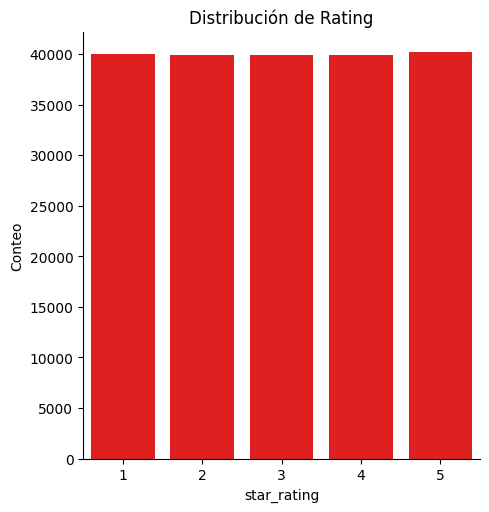

In [12]:
sns.catplot(x='star_rating', kind='count', color='r', data=df_train)
plt.title('Distribución de Rating')
plt.xlabel('star_rating')
plt.ylabel('Conteo')

# Modelamiento por Arquitecturas

In [13]:
import re
import nltk
from nltk.corpus import stopwords
stemmer = nltk.stem.SnowballStemmer('english')
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pms_l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## BOW

In [14]:
def processing_text(texto):
    # Paso 1: Remover con un expresión regular carateres especiales (no palabras).
    processed_feature = re.sub(r'\W', ' ', str(texto))
    # Paso 2: Remover ocurrencias de caracteres individuales
    processed_feature= re.sub(r'\s+[a-zA-Z]\s+', ' ', processed_feature)
    processed_feature = re.sub(r'\^[a-zA-Z]\s+', ' ', processed_feature)
    # Paso 3: Remover números (Ocurrencias muy esporádicas en nuestro dataset)
    processed_feature = re.sub(r'[0-9]+', ' ', processed_feature)
    # Paso 4: Simplificar espacios concecutivos a un único espacio entre palabras
    processed_feature = re.sub(' +', ' ', processed_feature)
    # Paso 5: Pasar todo el texto a minúsculas
    processed_feature = processed_feature.lower()
    # Paso 6: Aplicar stemming. Es una forma de enviar las palabras a una raiz común simplificando de esta manera el vocabulario.
    #         por ejemplo las palabras (absurdo, absurdos) que estan en el review 2895 seran llevados a la raiz común "absurd"
    #         y de esta forma se evita tener dos palabras diferentes con el mismo significado en nuestro vocabulario.
    processed_feature = " ".join([stemmer.stem(i) for i in processed_feature.split()])

    return processed_feature

In [15]:

# texto_para_procesar y labels respectivamente
texto_para_procesar = df_train['text'].values
labels = df_train['star_rating'].values

# El texto ya procesado de cada ejemplo en nuestro dataset lo almacenaremos en la variable "texto_procesado"
texto_procesado = []
for sentence in range(0, len(texto_para_procesar)):
    procesado = processing_text(texto_para_procesar[sentence])
    texto_procesado.append(procesado)

## Naives Bayes (MultinomialNB)

In [16]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay

In [17]:
def create_model_naives(texto_features):
    # Partición del dataset: Seleccionar 80% para entrenamiento, 20% pruebas.
    X_train, X_test, y_train, y_test = train_test_split(texto_features, labels, test_size=0.2, random_state=0)

    # Modelo: Naive Bayes
    model = MultinomialNB()
    model.fit(X_train, y_train)

    # Reporte de clasificación
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions, digits=4))

    # Matriz de confusión
    cm = confusion_matrix(y_test, predictions,labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

    return model

### Representacion 1

              precision    recall  f1-score   support

           1     0.4873    0.7344    0.5859      7952
           2     0.4481    0.2968    0.3571      7989
           3     0.4802    0.3228    0.3861      8169
           4     0.4901    0.3773    0.4264      7940
           5     0.5290    0.7400    0.6170      7950

    accuracy                         0.4932     40000
   macro avg     0.4870    0.4943    0.4745     40000
weighted avg     0.4869    0.4932    0.4739     40000



MultinomialNB()

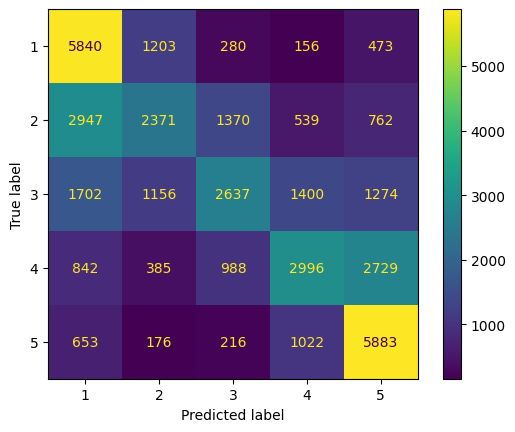

In [18]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=1000, stop_words=stopwords.words('english'))

# Construimos el vocabulario y tambien transformamos el texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_naives(texto_features)

### Representacion 2


              precision    recall  f1-score   support

           1     0.4917    0.7413    0.5912      7952
           2     0.4591    0.3054    0.3668      7989
           3     0.4836    0.3292    0.3917      8169
           4     0.5031    0.3728    0.4282      7940
           5     0.5322    0.7532    0.6237      7950

    accuracy                         0.4993     40000
   macro avg     0.4939    0.5004    0.4803     40000
weighted avg     0.4938    0.4993    0.4798     40000



MultinomialNB()

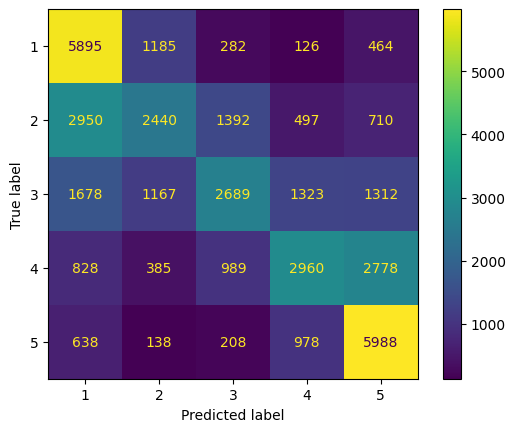

In [19]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=2500, stop_words=stopwords.words('english'))

# Construimos el vocabulario y tambien transformamos el texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_naives(texto_features)

### Representacion 3


              precision    recall  f1-score   support

           1     0.4908    0.7412    0.5906      7952
           2     0.4597    0.3060    0.3674      7989
           3     0.4835    0.3300    0.3923      8169
           4     0.5047    0.3723    0.4285      7940
           5     0.5339    0.7548    0.6255      7950

    accuracy                         0.4998     40000
   macro avg     0.4945    0.5009    0.4808     40000
weighted avg     0.4944    0.4998    0.4803     40000



MultinomialNB()

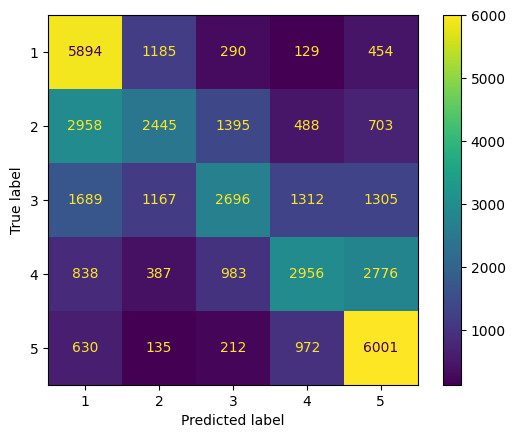

In [20]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=3000, stop_words=stopwords.words('english'))

# Construimos el vocabulario y tambien transformamos el texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_naives(texto_features)

## Logistic Regresion (SDGClassfier)

In [21]:
from sklearn.linear_model import SGDClassifier

In [22]:
def create_model_sdg(texto_features, eta = 0.1):
    # Partición del dataset: Seleccionar 80% para entrenamiento, 20% pruebas.
    X_train, X_test, y_train, y_test = train_test_split(
        texto_features, labels, test_size=0.2, random_state=0)

    # Modelo: SGDClassifier
    model = SGDClassifier(loss='log_loss', learning_rate='constant', eta0=eta)
    model.fit(X_train, y_train)

    # Reporte de clasificación
    predictions = model.predict(X_test)
    print(classification_report(y_test, predictions, digits=4))

    # Matriz de confusión
    cm = confusion_matrix(y_test, predictions, labels=model.classes_)
    disp = ConfusionMatrixDisplay(
        confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

    return model

### Representacion 1

              precision    recall  f1-score   support

           1     0.4246    0.1141    0.1798      7952
           2     0.2150    0.1644    0.1863      7989
           3     0.2374    0.0588    0.0942      8169
           4     0.2453    0.6440    0.3552      7940
           5     0.3219    0.3599    0.3398      7950

    accuracy                         0.2668     40000
   macro avg     0.2888    0.2682    0.2311     40000
weighted avg     0.2885    0.2668    0.2302     40000



SGDClassifier(eta0=100, learning_rate='constant', loss='log_loss')

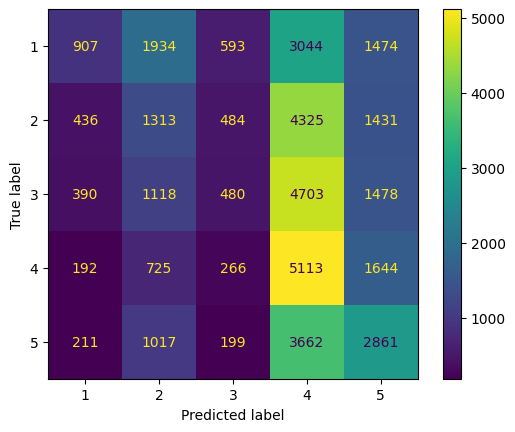

In [23]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=3000, stop_words=stopwords.words('english'))

# Construimos el vocabulario y tambien transformamos el texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_sdg(texto_features,eta=100)

### Representacion 2

In [24]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=3000, stop_words=stopwords.words('english'))

# Construimos el vocabulario y tambien transformamos el texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_sdg(texto_features,eta=10)

### Representacion 3

              precision    recall  f1-score   support

           1     0.5719    0.7707    0.6566      7952
           2     0.4847    0.3545    0.4095      7989
           3     0.5072    0.3879    0.4396      8169
           4     0.5055    0.4712    0.4877      7940
           5     0.6055    0.7459    0.6684      7950

    accuracy                         0.5450     40000
   macro avg     0.5350    0.5460    0.5324     40000
weighted avg     0.5348    0.5450    0.5318     40000



SGDClassifier(eta0=0.0001, learning_rate='constant', loss='log_loss')

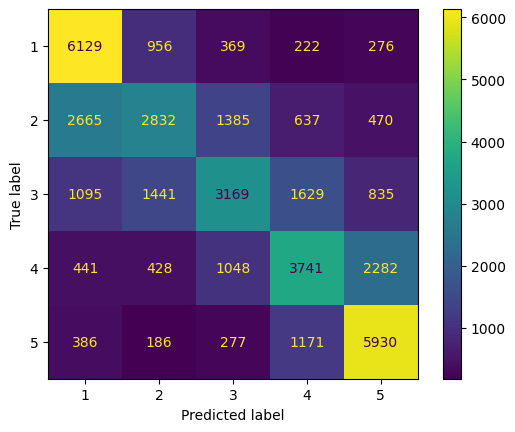

In [ ]:
# Bolsa de palabras
vectorizer = CountVectorizer(max_features=3000, stop_words=stopwords.words('english'))

# Construimos el vocabulario y tambien transformamos el texto
texto_features = vectorizer.fit_transform(texto_procesado).toarray().astype("float16")

# Creamos el modelo y sus metricas
create_model_sdg(texto_features,eta=0.0001)

## Recurrent Neural Network (LSTM - Long short-term memory)

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

In [ ]:
X = df_train['text'].values
y = df_train['star_rating'].values

In [ ]:
# Transformar las etiquetas categóricas en valores numéricos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded)

### Representacion 1

In [ ]:
max_words = 10000
max_sequence_length = 100

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

KeyboardInterrupt: ignored

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

In [ ]:
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(Dense(5, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
batch_size = 64
epochs = 50
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss en el conjunto de prueba: {loss}, Accuracy en el conjunto de prueba: {accuracy}')

In [ ]:
# Reporte de Clasificación
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

class_labels = label_encoder.classes_.astype(str)

classification_rep = classification_report(y_test_labels, y_pred_labels, target_names=class_labels)

print("Reporte de clasificación:")
print(classification_rep)

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()

### Representacion 2

In [ ]:
max_words = 20000
max_sequence_length = 100

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

In [ ]:
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
model.add(LSTM(128))
model.add(layers.Dense(80, activation='relu'))
model.add(layers.Dense(45, activation='relu'))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
batch_size = 32
epochs = 10
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss en el conjunto de prueba: {loss}, Accuracy en el conjunto de prueba: {accuracy}')

In [ ]:
# Reporte de Clasificación
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

class_labels = label_encoder.classes_.astype(str)

classification_rep = classification_report(y_test_labels, y_pred_labels, target_names=class_labels)

print("Reporte de clasificación:")
print(classification_rep)

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()

### Representacion 3

In [ ]:
max_words = 10000
max_sequence_length = 100

In [ ]:
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X)
X_sequences = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_sequences, maxlen=max_sequence_length)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

In [ ]:
embedding_dim = 100
model = Sequential()
model.add(Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_sequence_length))
# model.add(LSTM(128))
model.add(layers.Dense(50, activation='relu'))
# model.add(layers.Dropout(0.1))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
batch_size = 64
epochs = 15
model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Loss en el conjunto de prueba: {loss}, Accuracy en el conjunto de prueba: {accuracy}')

In [ ]:
# Reporte de Clasificación
y_pred = model.predict(X_test)
y_pred_labels = np.argmax(y_pred, axis=1)
y_test_labels = np.argmax(y_test, axis=1)

class_labels = label_encoder.classes_.astype(str)

classification_rep = classification_report(y_test_labels, y_pred_labels, target_names=class_labels)

print("Reporte de clasificación:")
print(classification_rep)

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicciones')
plt.ylabel('Etiquetas verdaderas')
plt.title('Matriz de Confusión')
plt.show()